**このコードでは、欠損値を含んでいるdata/city_aqi_dataフォルダー内のデータの欠損値処理を行うと同時に、大気汚染物質六つとAQI値の特徴を掴むために、変動成分と定常性、自己相関とともに、説明変数と他の目的変数との相関関係を調べていく**

前提として、

*   Data_preprocessing_1とData_preprocessing_city&AQI_2を動かしていること
*   説明変数として、指定したフォルダーに東京とデリーのcsvデータが存在していること

が前提となっている

**注意事項**

※ 作成者はGoogle drive内で作業をしていると同時に、ゼミというフォルダーの中の公開ソースというフォルダーで作業していることからpathの変更は必要不可欠である

## 初期設定

In [ ]:
#Google driveに接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ast import increment_lineno
import seaborn as sns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
! pip install japanize-matplotlib
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c842986e188ee4c1253b4ab4cfa0c112000d91d08f520a50bbc961e0e3b4cfc9
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
# ※※自分で作成したフォルダパスが異なる場合こちらを変更してください。※※
working_dir = '/content/drive/MyDrive/ゼミ/公開ソース'
path_missing = f'{working_dir}/data/city_aqi_data'

In [ ]:
#フォルダーの中身を確認
os.listdir(path_missing)

['Delhi_AQI.csv', 'Tokyo_AQI.csv']

In [ ]:
#フォルダーのデータを読み取り
for i in (os.listdir(path_missing)):
  name = i.partition('_')[0]
  df = pd.read_csv(f"{path_missing}/{i}",index_col='Date',parse_dates=True)
  print(name)
  exec("{}=df".format(name))

Delhi
Tokyo


# 1.説明変数の欠損値補充

欠損値の補充に関しては、国土交通省内の気象省の過去の気象データからTokyoとDelhiのデータを取り出している。

*  Tokyoの過去の気象データをダウンロードするwebサイト(気温、湿度、気圧、風速、降水)

 >  https://www.data.jma.go.jp/risk/obsdl/index.php



*  Delhiの過去の気象データをダウンロードするwebサイト(※気温、降水量のみでダウンロードでは)

 > https://www.data.jma.go.jp/gmd/cpd/monitor/dailyview/graph_mkhtml_d.php?&n=42182&p=183&s=3&r=1&y=2019&m=6&d=31&e=3&k=0


※ Tokyoのデータに関しては、期間を指定して欲しいデータを一つのcsvとしてダウンロードすることができるが、Delhiのデータに関しては半年ごとのデータしかダウンロードor表示しかできないため、改めて新しいcsvファイルを作成して今回の欠損値補充に使用している

※ インドのデリーのデータはなかったため、ニューデリーの説明変数値をデリーの説明変数の欠損値を補充する値としている


## Tokyoのデータ処理

※ Tokyoの説明変数では、ダウンロードしてきたデータですべて入れ替えるという作業を行い、欠損値の処理とする

In [ ]:
#確認
Tokyo
# Delhi

,humidity,precipitation,pressure,temperature,wind-speed,co,so2,pm25,pm10,o3,no2,aqi_co,aqi_so2,aqi_pm25,aqi_pm10,aqi_o3_1,aqi_no2,AQI_total
Date,,,,,,,,,,,,,,,,,,
2019-01-01,16.0,NaN,1021.0,2.5,0.5,0.34,0.0015,38.0,10.0,0.0168,0.0139,4,2,95,9,0,0,95
2019-01-02,16.0,NaN,1018.0,3.3,0.6,0.34,0.0015,17.0,5.0,0.0241,0.0084,4,2,54,5,0,0,54
2019-01-03,16.0,NaN,1021.0,2.5,0.7,0.23,0.0015,17.0,5.0,0.0248,0.0084,3,2,54,5,0,0,54
2019-01-04,16.0,NaN,1022.0,2.2,0.2,0.45,0.0029,34.0,9.0,0.0184,0.0176,5,4,87,8,0,0,87
2019-01-05,16.0,NaN,1012.5,3.0,0.5,0.45,0.0015,50.0,11.0,0.0160,0.0213,5,2,120,10,0,0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,57.0,NaN,1019.0,18.0,1.1,0.34,0.0015,25.0,8.0,0.0224,0.0121,4,2,70,7,0,0,70
2023-10-31,66.0,99.0,1021.5,18.3,0.8,0.45,0.0029,42.0,13.0,0.0160,0.0195,5,4,104,12,0,0,104
2023-11-01,70.0,NaN,1018.0,19.0,1.1,0.45,0.0029,53.0,16.0,0.0248,0.0167,5,4,126,15,0,0,126


In [ ]:
#東京のデータフレームにて欠損値がどの程度存在するかを確認
Tokyo.isnull().sum()

humidity          18
precipitation    974
pressure          18
temperature       18
wind-speed        88
co                 0
so2                0
pm25               0
pm10               0
o3                 0
no2                0
aqi_co             0
aqi_so2            0
aqi_pm25           0
aqi_pm10           0
aqi_o3_1           0
aqi_no2            0
AQI_total          0
dtype: int64

In [ ]:
#Tokyoの欠損値の補充
#Tokyoの説明変数として使用する気温と湿度、気圧、風速と降水量は。
#説明変数フォルダーから東京のデータを取得する

path_tokyo_ex = f"{working_dir}/data/explanatory_variables/Tokyo_explanatory_variables.csv"

df_tokyo_ex = pd.read_csv(f"{path_tokyo_ex}",index_col="年月日",parse_dates=True)
df_concat_tokyo = pd.concat([df_tokyo_ex,Tokyo],axis=1)

In [ ]:
#大気汚染物質のデータで欠損している値があるため、そちらを把握
print(df_concat_tokyo[df_concat_tokyo['pm10'].isnull()].index)

DatetimeIndex(['2019-04-14', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-12', '2020-09-13'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
#リスト化
#ここで、東京のデータには7日分のデータが無いことがわかる
lists_date_null = ['2019-04-14', '2020-09-08', '2020-09-09', '2020-09-10','2020-09-11', '2020-09-12', '2020-09-13']

#リスト化した値の行を削除
df_date_drop_t = df_concat_tokyo.drop(index=lists_date_null)

In [ ]:
#必要ない列を削除しつつ、説明変数として追加したcolumn名を変更
lists_drop = ["precipitation","temperature","wind-speed","pressure","humidity","aqi_co","aqi_so2","aqi_pm25","aqi_pm10","aqi_o3_1","aqi_no2"]
lists_ex = ["precipitation","temperature","wind-speed","pressure","humidity"]
df_tokyo_drop = df_date_drop_t.drop(lists_drop,axis=1)
for number,ex_name in enumerate(lists_ex):
  df_tokyo_drop = df_tokyo_drop.rename(columns={df_tokyo_drop.columns[number]:lists_ex[number]})


In [ ]:
df_tokyo_drop

,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,AQI_total
2019-01-01,0.0,5.3,2.3,1019.6,54,0.34,0.0015,38.0,10.0,0.0168,0.0139,95.0
2019-01-02,0.0,6.2,2.9,1017.7,47,0.34,0.0015,17.0,5.0,0.0241,0.0084,54.0
2019-01-03,0.0,4.9,3.1,1020.2,49,0.23,0.0015,17.0,5.0,0.0248,0.0084,54.0
2019-01-04,0.0,5.1,2.0,1023.0,59,0.45,0.0029,34.0,9.0,0.0184,0.0176,87.0
2019-01-05,0.0,7.4,2.1,1010.6,52,0.45,0.0015,50.0,11.0,0.0160,0.0213,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,0.0,16.9,2.0,1017.5,62,0.34,0.0015,25.0,8.0,0.0224,0.0121,70.0
2023-10-31,0.0,17.2,1.6,1019.7,72,0.45,0.0029,42.0,13.0,0.0160,0.0195,104.0
2023-11-01,0.0,18.0,2.3,1016.8,72,0.45,0.0029,53.0,16.0,0.0248,0.0167,126.0
2023-11-02,0.0,18.2,1.4,1015.1,68,0.45,0.0015,63.0,21.0,0.0136,0.0232,145.0


In [ ]:
#ここでTokyoのデータに欠損値はなくなったことを確認
df_tokyo_drop.isnull().sum()

precipitation    0
temperature      0
wind-speed       0
pressure         0
humidity         0
co               0
so2              0
pm25             0
pm10             0
o3               0
no2              0
AQI_total        0
dtype: int64

## Delhiのデータ処理

※ Delhiの説明変数では、降水量と気温のデータのみを外部からダウンロードしてきたデータに置き換え、湿度と気圧に関しては大気汚染物質データと共に取得した説明変数のデータの平均値を欠損値を補填する値としている

In [ ]:
#デリーでも同様に
Delhi.isnull().sum()

humidity           16
precipitation    1332
pressure           16
temperature        16
co                  0
so2                 0
pm25                0
pm10                0
o3                  0
no2                 0
aqi_co              0
aqi_so2             0
aqi_pm25            0
aqi_pm10            0
aqi_o3_1            0
aqi_no2             0
AQI_total           0
dtype: int64

In [ ]:
path_delhi = f"{working_dir}/data/explanatory_variables/Delhi_explanatory_variables.csv"
df_delhi_ex = pd.read_csv(path_delhi)

In [ ]:
#日付が年と月、日でバラバラなため一つにまとめる
df_delhi_ex['日付'] = df_delhi_ex["年"].astype(str) + "-" + df_delhi_ex["月"].astype(str) + "-" + df_delhi_ex["日"].astype(str)
df_delhi_ex = df_delhi_ex.set_index("日付")
df_delhi_ex.index = pd.to_datetime(df_delhi_ex.index)

In [ ]:
#必要ない列を削除
df_delhi_ex = df_delhi_ex.drop(["年","月","日", "日最高気温","日最低気温","Unnamed: 7"],axis=1)

In [ ]:
df_concat_d = pd.concat([df_delhi_ex,Delhi],axis=1)

In [ ]:
df_concat_d

,日平均気温,日降水量,humidity,precipitation,pressure,temperature,co,so2,pm25,pm10,o3,no2,aqi_co,aqi_so2,aqi_pm25,aqi_pm10,aqi_o3_1,aqi_no2,AQI_total
2019-01-01,13.7,0.0,71.9,1.0,996.1,13.0,1.76,0.0093,341.0,354.0,0.0041,0.0290,20.0,14.0,391.0,200.0,0.0,0.0,391.0
2019-01-02,14.2,0.0,75.7,405.3,996.5,13.8,1.99,0.0087,383.0,405.0,0.0045,0.0319,23.0,13.0,422.0,273.0,0.0,0.0,422.0
2019-01-03,13.6,0.0,79.0,0.5,997.5,13.0,1.85,0.0071,410.0,421.0,0.0043,0.0288,21.0,10.0,440.0,296.0,0.0,0.0,440.0
2019-01-04,12.4,0.0,81.7,34.4,996.5,12.3,1.50,0.0065,289.0,220.0,0.0038,0.0236,17.0,10.0,339.0,133.0,0.0,0.0,339.0
2019-01-05,13.8,0.8,70.3,44.7,994.3,13.9,1.56,0.0076,304.0,266.0,0.0053,0.0253,18.0,11.0,354.0,156.0,0.0,0.0,354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,24.6,0.0,58.7,NaN,989.2,26.2,1.41,0.0038,200.0,186.0,0.0098,0.0171,16.0,6.0,250.0,116.0,0.0,0.0,250.0
2023-10-31,24.3,0.0,65.0,1.5,989.1,26.2,1.48,0.0038,233.0,204.0,0.0090,0.0170,17.0,6.0,283.0,125.0,0.0,0.0,283.0
2023-11-01,23.9,0.0,64.3,NaN,990.4,25.5,1.29,0.0041,206.0,179.0,0.0080,0.0160,15.0,6.0,256.0,113.0,0.0,0.0,256.0
2023-11-02,23.2,0.0,69.0,NaN,990.7,24.6,1.72,0.0045,317.0,347.0,0.0063,0.0207,20.0,7.0,367.0,197.0,0.0,0.0,367.0


In [ ]:
#大気汚染物質のデータで欠損している値があるため、そちらを把握
print(df_concat_d[df_concat_d['pm10'].isnull()].index)

DatetimeIndex(['2019-04-14'], dtype='datetime64[ns]', freq='D')


In [ ]:
#リスト化
#ここで、デリーのデータには1日分のデータが無いことがわかる
lists_date_null = ['2019-04-14']

#リスト化した値の行を削除
df_all_delhi = df_concat_d.drop(index=lists_date_null)

In [ ]:
#必要ない列を削除しつつ、名前を変更
df_delhi_drop = df_all_delhi.drop(["precipitation","temperature","aqi_co","aqi_so2","aqi_pm25","aqi_pm10","aqi_o3_1","aqi_no2"],axis=1)
df_delhi_drop = df_delhi_drop.rename(columns={"日平均気温":"temperature","日降水量":"precipitation"})

In [ ]:
#湿度と気圧に関してはデータが存在しなかっため、データフレーム内の平均値を欠損値に当てはめる
df_delhi_drop.mean()

temperature       25.348331
precipitation      2.303565
humidity          61.868932
pressure         985.563621
co                 0.976384
so2                0.005172
pm25             157.533107
pm10             123.115450
o3                 0.008488
no2                0.014829
AQI_total        215.441426
dtype: float64

In [ ]:
df_delhi_drop = df_delhi_drop.fillna({'humidity':61.8, 'pressure': 985.5})

In [ ]:
#デリーも欠損値がなくなった
df_delhi_drop.isnull().sum()

temperature      0
precipitation    0
humidity         0
pressure         0
co               0
so2              0
pm25             0
pm10             0
o3               0
no2              0
AQI_total        0
dtype: int64

## データフレームの保存


In [ ]:
#データフレームのインデックスの名前をDateと指定
df_tokyo_drop = df_tokyo_drop.rename_axis("Date")
df_delhi_drop = df_delhi_drop.rename_axis("Date")

In [ ]:
#論文に使用するデータという意味でそれぞれpaperという名前で保存する
path_datafolder = f"{working_dir}/data/traninig_validation_test_data"

df_tokyo_drop.to_csv(f"{path_datafolder}/Tokyo_paper.csv")
df_delhi_drop.to_csv(f"{path_datafolder}/Delhi_paper.csv")

# 2.目的変数の特徴を掴む

In [ ]:
#Google driveに接続(必要な場合のみ動かす)

# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#上で作成したデータフレームを読み込み
working_dir = '/content/drive/MyDrive/ゼミ/公開ソース' #　※※自分で作成したフォルダパスが異なる場合こちらを変更してください。※※
path_df_city = f'{working_dir}/data/traninig_validation_test_data'
os.chdir(path_df_city)

In [ ]:
#それぞれの都市のデータを読み込む
for i in (os.listdir(path_df_city)):
  name = i.partition('_')[0]
  df = pd.read_csv(f"{path_df_city}/{i}",index_col=0,parse_dates=True)
  print(name)
  exec("{}=df".format(name))

Tokyo
Delhi


In [ ]:
#確認
Tokyo

,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,aqi_co,aqi_so2,aqi_pm25,aqi_pm10,aqi_o3_1,aqi_no2,AQI_total
Date,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,5.3,2.3,1019.6,54,0.34,0.0015,38.0,10.0,0.0168,0.0139,4.0,2.0,95.0,9.0,0.0,0.0,95.0
2019-01-02,0.0,6.2,2.9,1017.7,47,0.34,0.0015,17.0,5.0,0.0241,0.0084,4.0,2.0,54.0,5.0,0.0,0.0,54.0
2019-01-03,0.0,4.9,3.1,1020.2,49,0.23,0.0015,17.0,5.0,0.0248,0.0084,3.0,2.0,54.0,5.0,0.0,0.0,54.0
2019-01-04,0.0,5.1,2.0,1023.0,59,0.45,0.0029,34.0,9.0,0.0184,0.0176,5.0,4.0,87.0,8.0,0.0,0.0,87.0
2019-01-05,0.0,7.4,2.1,1010.6,52,0.45,0.0015,50.0,11.0,0.0160,0.0213,5.0,2.0,120.0,10.0,0.0,0.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,0.0,16.9,2.0,1017.5,62,0.34,0.0015,25.0,8.0,0.0224,0.0121,4.0,2.0,70.0,7.0,0.0,0.0,70.0
2023-10-31,0.0,17.2,1.6,1019.7,72,0.45,0.0029,42.0,13.0,0.0160,0.0195,5.0,4.0,104.0,12.0,0.0,0.0,104.0
2023-11-01,0.0,18.0,2.3,1016.8,72,0.45,0.0029,53.0,16.0,0.0248,0.0167,5.0,4.0,126.0,15.0,0.0,0.0,126.0


## 変動成分のグラフを作成する関数

In [ ]:
#データの特徴を読み取るグラフを保存するフォルダーを指定
graph_path = f'{working_dir}/result/graph/data_features'

In [ ]:
#データの特徴を読み取るデータフレームを保存するフォルダーを指定
df_path = f"{working_dir}/result/data/data_features"

In [ ]:
#変動分析を行う関数を作成
def create_graph_fluctuation(df,City_name):
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
    plt.style.use('ggplot') #グラフのスタイル
    plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
    stl=STL(df[column_name], period=365, robust=True).fit()
    # STL分解結果のグラフ化
    stl.plot()
    plt.savefig(f'{graph_path}/{City_name}_{column_name}.png')
    plt.show()

In [ ]:
#東京とデリーのデータを変動分析関数にて分析する
create_graph_fluctuation(Tokyo,"Tokyo")
create_graph_fluctuation(Delhi,"Delhi")

Output hidden; open in https://colab.research.google.com to view.

## 定常性

In [ ]:
#結果を保存するためのデータフレーム作成
stationarity_df = pd.DataFrame(columns=["ADF_Statistic","p-value","Critical_values1%","Critical_values5%","Critical_values10%"])

In [ ]:
#小数点が多いため、あらかじめ切り捨てる位を設定
pd.options.display.float_format = '{:.7f}'.format

#定常性を確認するためのデータフレームを作成する関数
def create_stationarity_df(df,City_name):
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
    dftest = adfuller(df[column_name])
    critical_v = []
    for k, v in dftest[4].items():
      critical_v.append(v)
    gg = float(dftest[1])
    row = [dftest[0],gg,critical_v[0],critical_v[1],critical_v[2]]

    stationarity_df.loc[f"{City_name}_{column_name}"] = row
  return stationarity_df


In [ ]:
#関数を動かす
create_stationarity_df(Tokyo,"Tokyo")
create_stationarity_df(Delhi,"Delhi")

<ipython-input-44-8c51757a4414>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
<ipython-input-44-8c51757a4414>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():


,ADF_Statistic,p-value,Critical_values1%,Critical_values5%,Critical_values10%
Tokyo_pm25,-14.3631120,0.0000000,-3.4340794,-2.8631873,-2.5676470
Tokyo_o3,-3.8861243,0.0021394,-3.4341030,-2.8631977,-2.5676525
Tokyo_pm10,-7.7481948,0.0000000,-3.4340987,-2.8631958,-2.5676515
Tokyo_so2,-4.9243970,0.0000313,-3.4341095,-2.8632006,-2.5676540
Tokyo_no2,-3.4306779,0.0099565,-3.4341246,-2.8632073,-2.5676576
Tokyo_co,-3.7900153,0.0030111,-3.4341138,-2.8632025,-2.5676551
Tokyo_AQI_total,-14.3319515,0.0000000,-3.4340794,-2.8631873,-2.5676470
Delhi_pm25,-3.7995461,0.0029120,-3.4340965,-2.8631949,-2.5676510
Delhi_o3,-4.4586020,0.0002334,-3.4340752,-2.8631855,-2.5676460
Delhi_pm10,-5.7740367,0.0000005,-3.4340816,-2.8631883,-2.5676475


In [ ]:
#保存
stationarity_df.to_csv(f"{df_path}/ADF_datafreme.csv")

## 自己・偏自己相関

In [ ]:
#自己相関と偏自己相関のグラフを作成するための関数
def create_self(df,city_name):
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
    acf = plot_acf(df[column_name], lags=400)
    plt.savefig(f'{graph_path}/{city_name}_{column_name}_Autocorrelation.png')
    pacf = plot_pacf(df[column_name], lags=40)
    plt.savefig(f'{graph_path}/{city_name}_{column_name}_Partial_Autocorrelation.png')

<ipython-input-47-1009d8bbf40f>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
<ipython-input-47-1009d8bbf40f>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, item in df[["pm25","o3","pm10","so2","no2","co","AQI_total"]].iteritems():
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


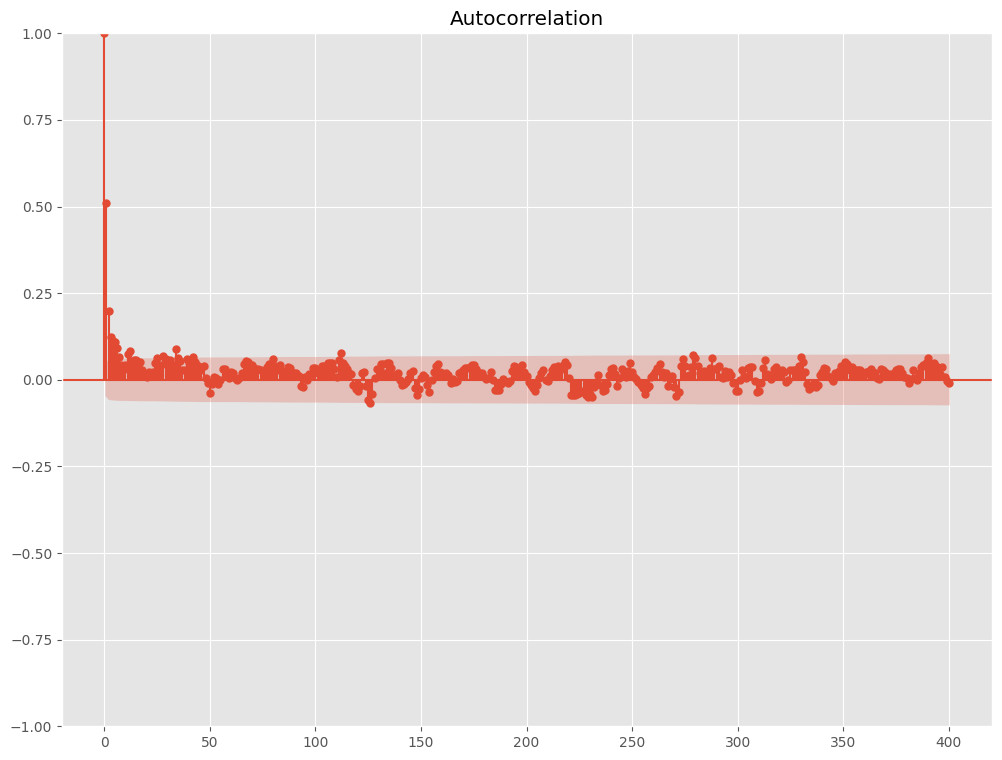

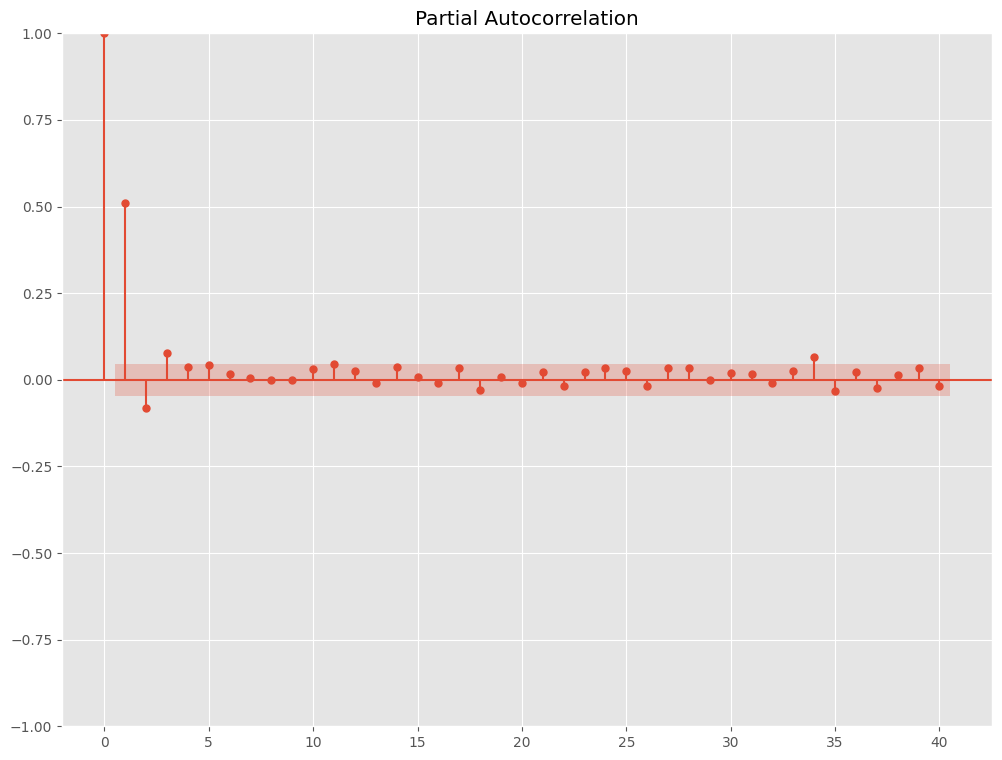

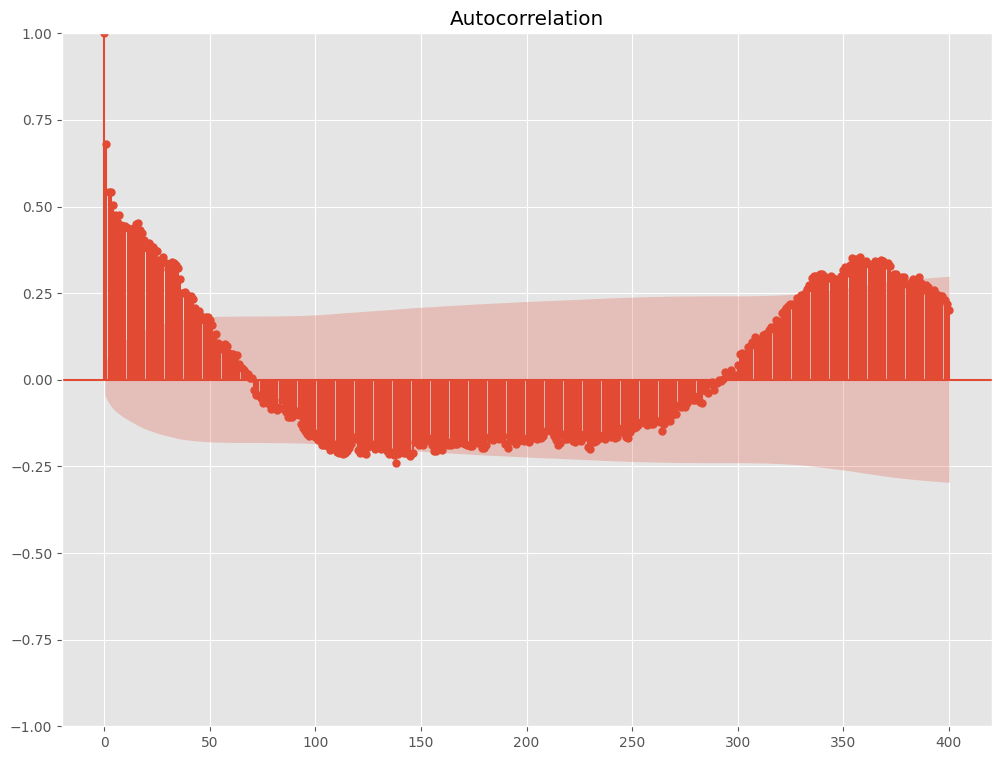

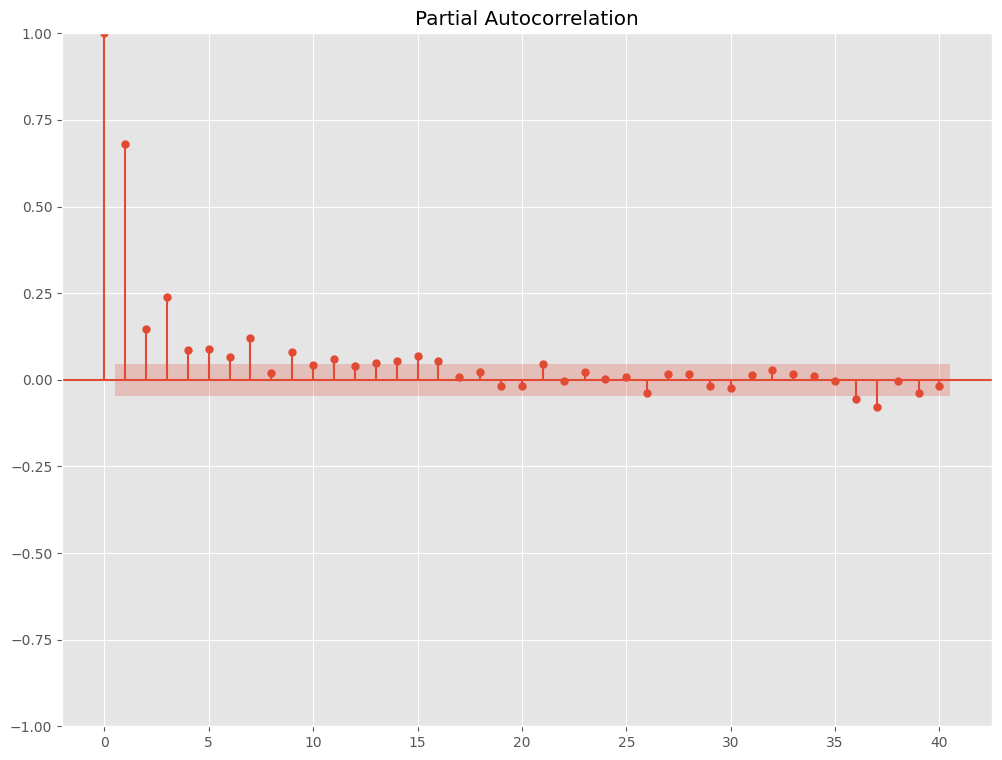

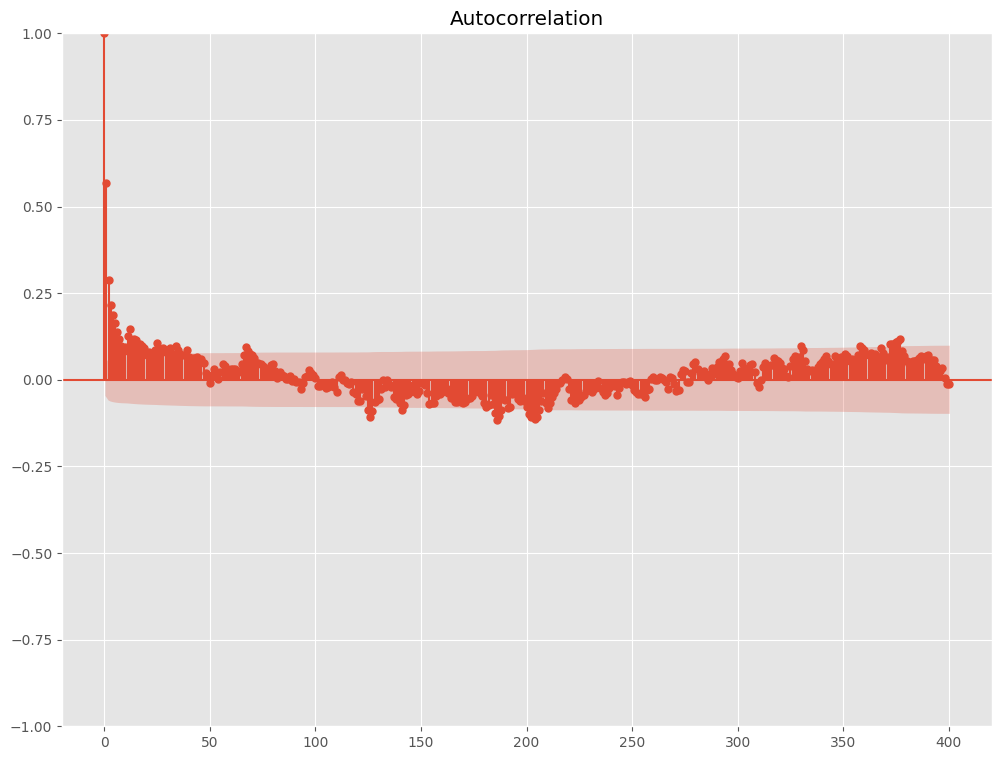

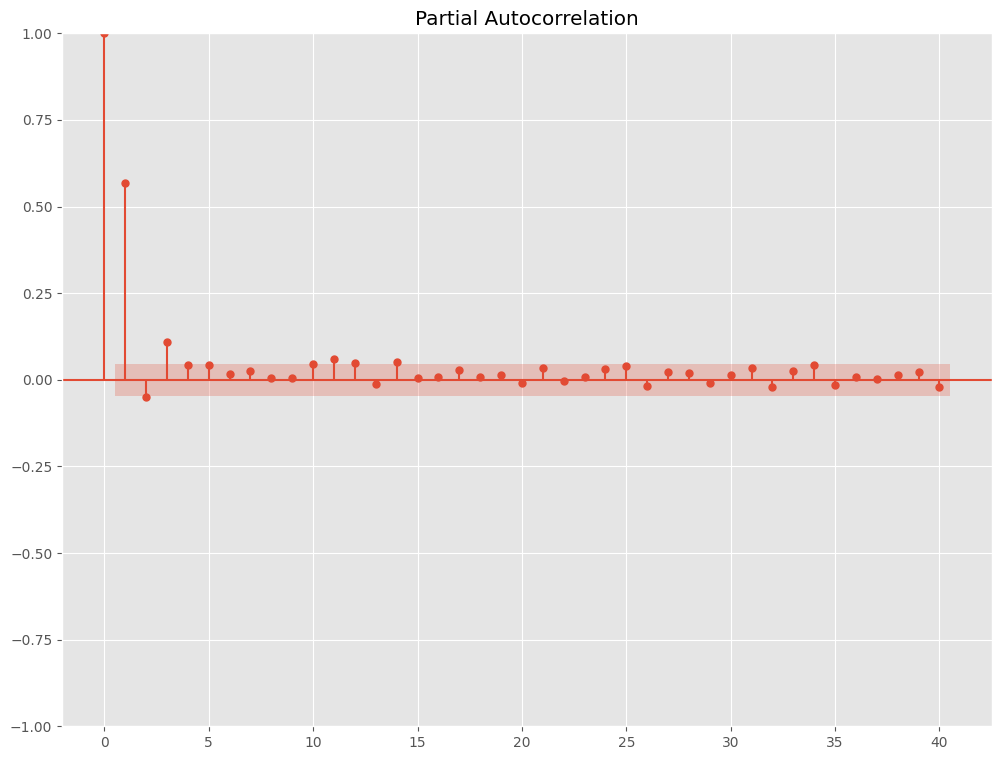

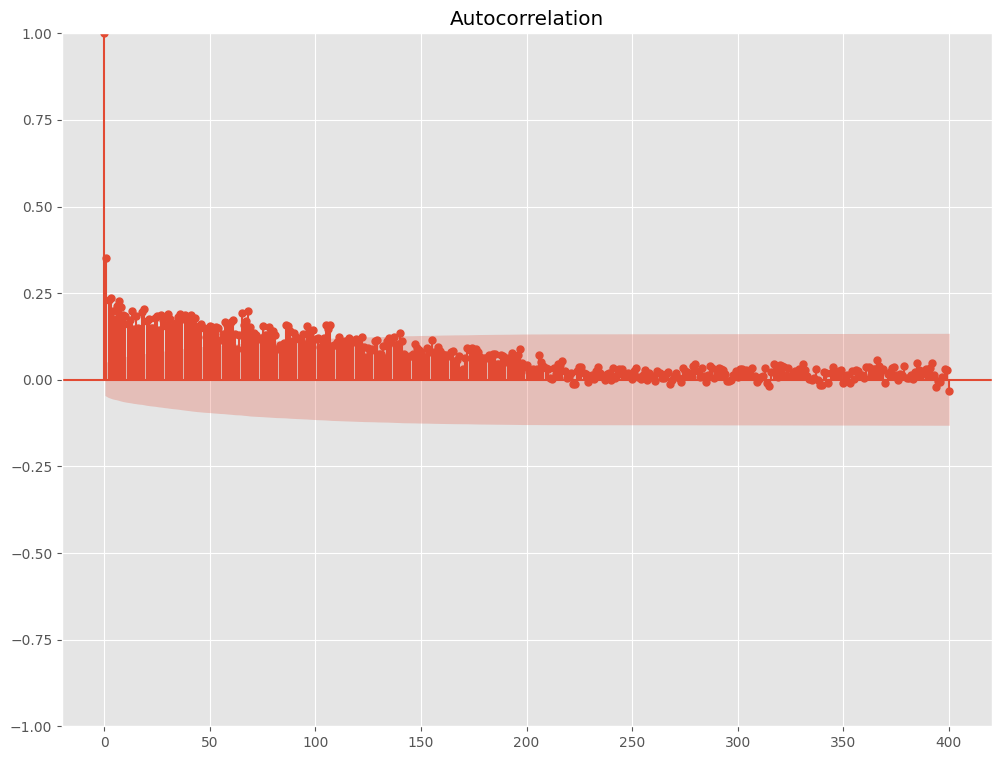

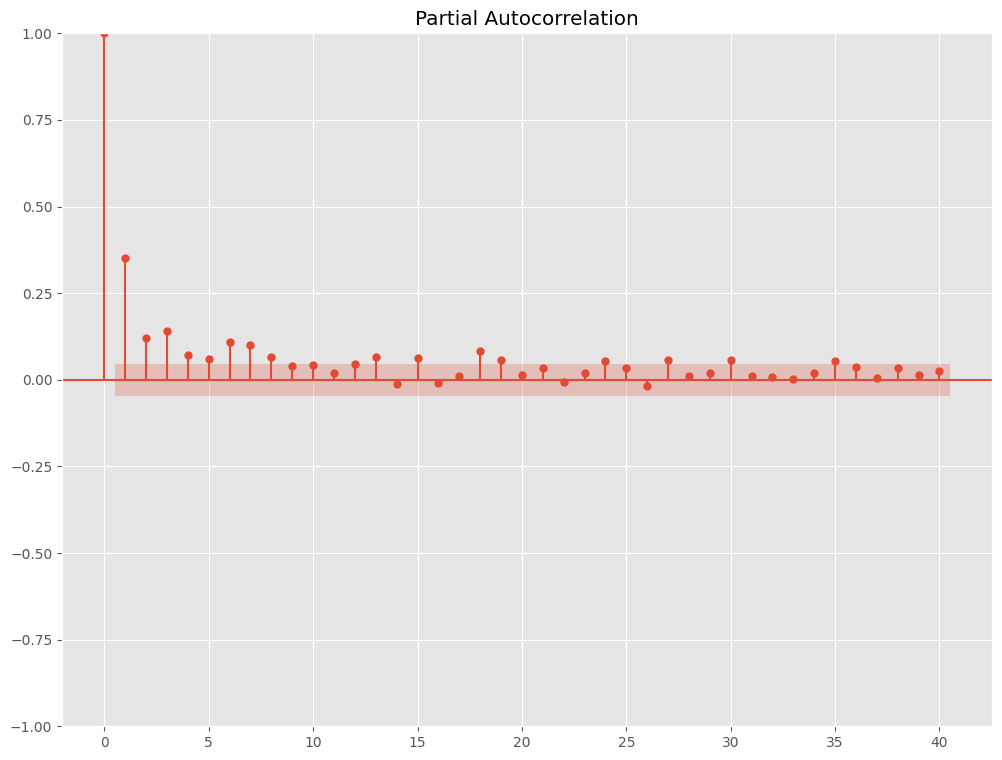

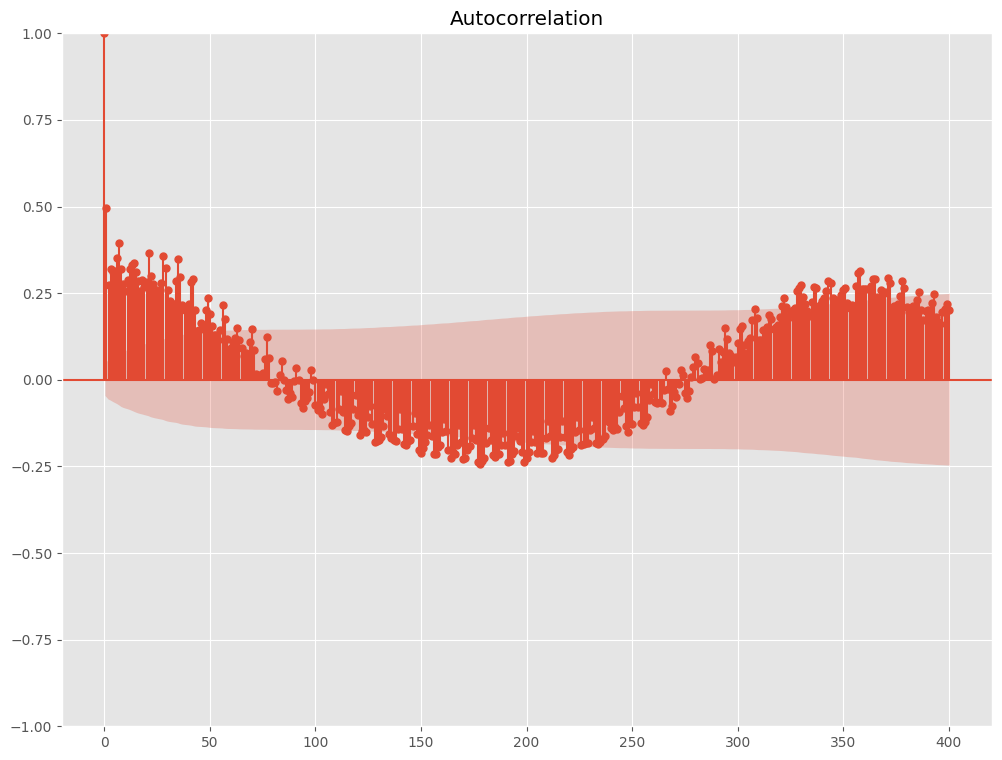

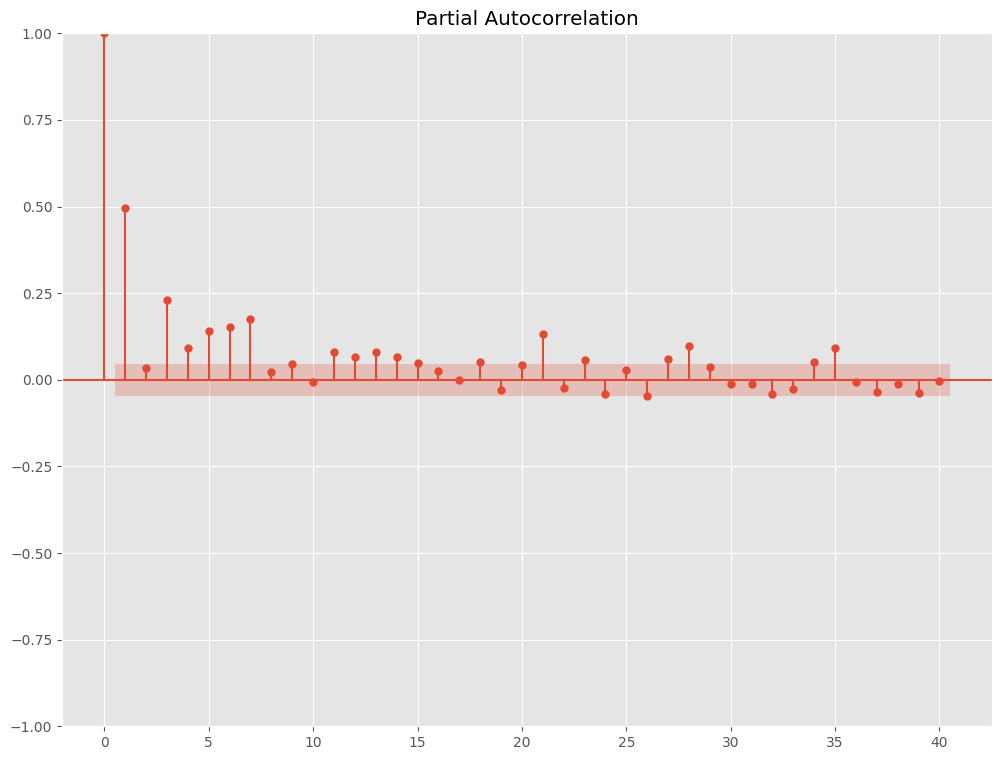

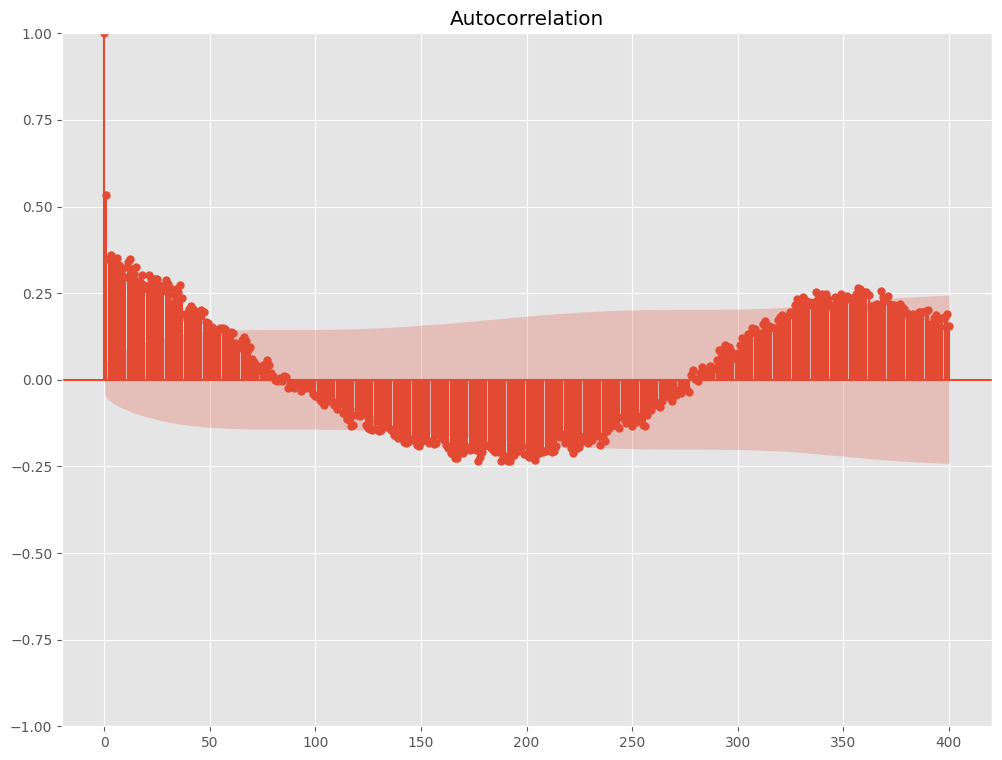

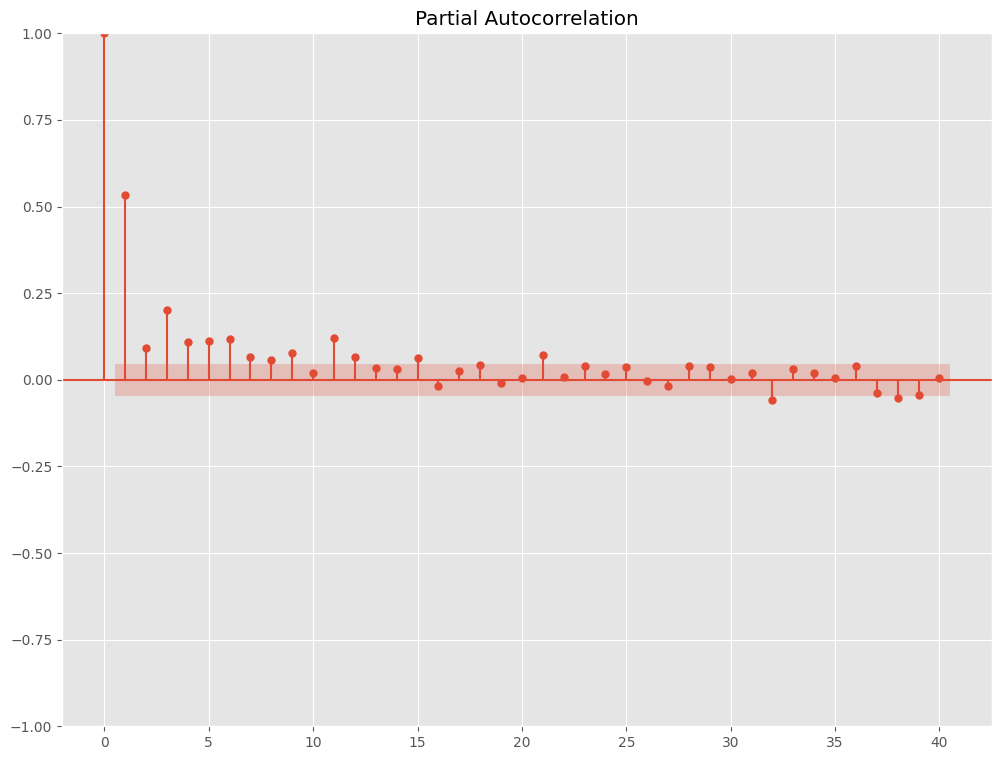

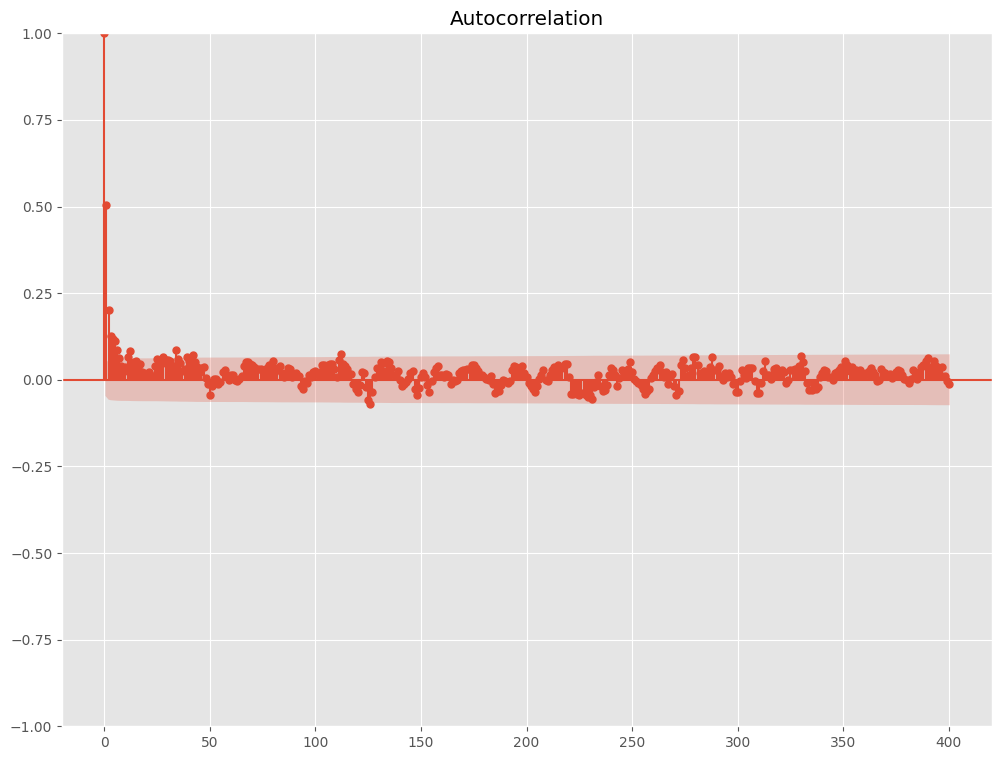

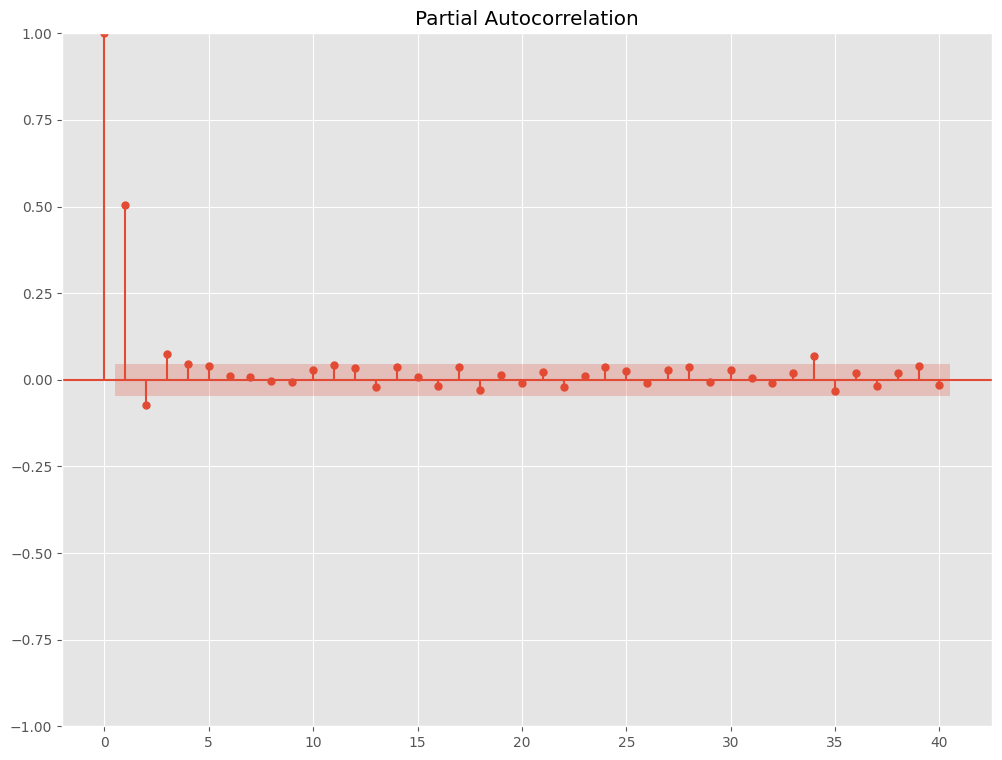

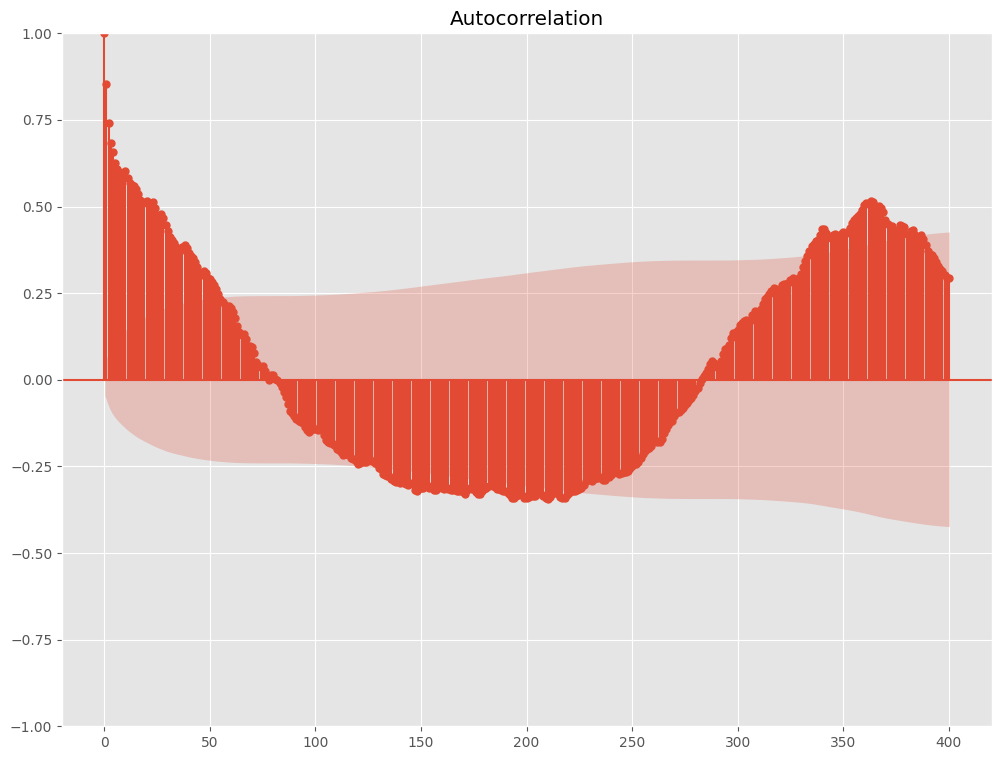

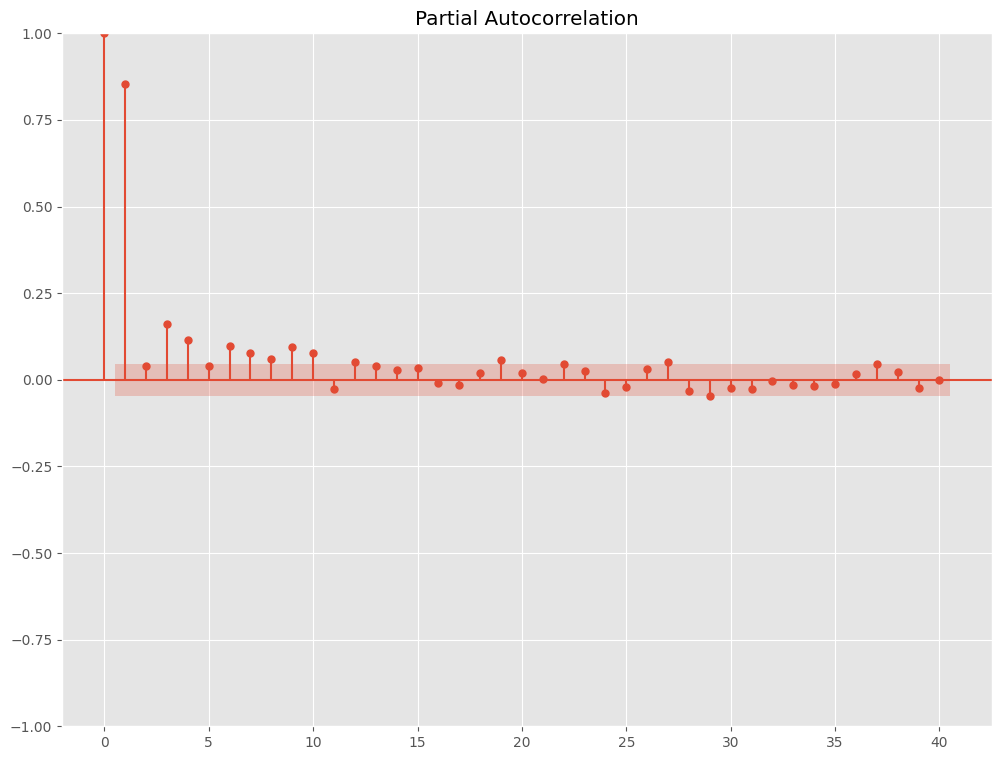

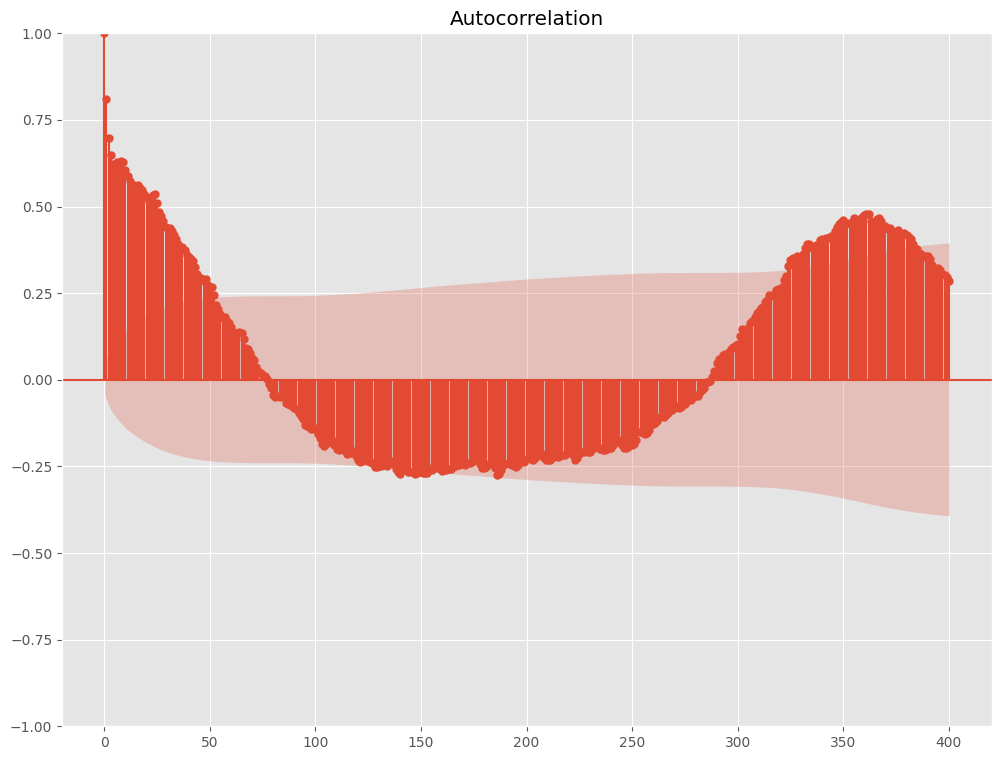

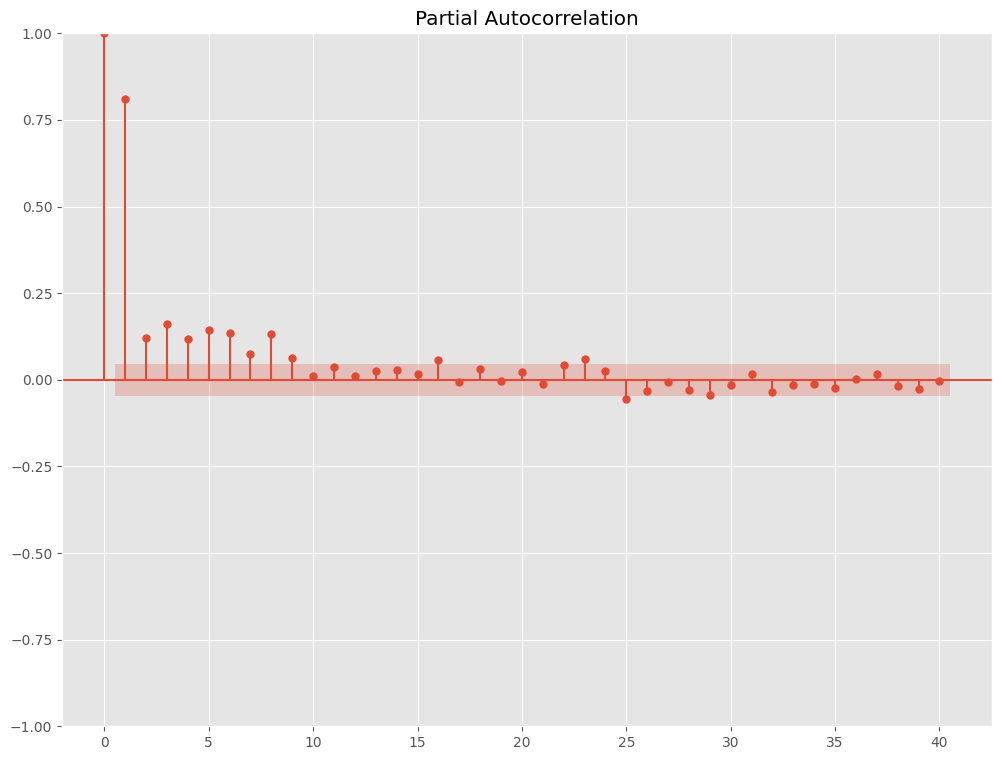

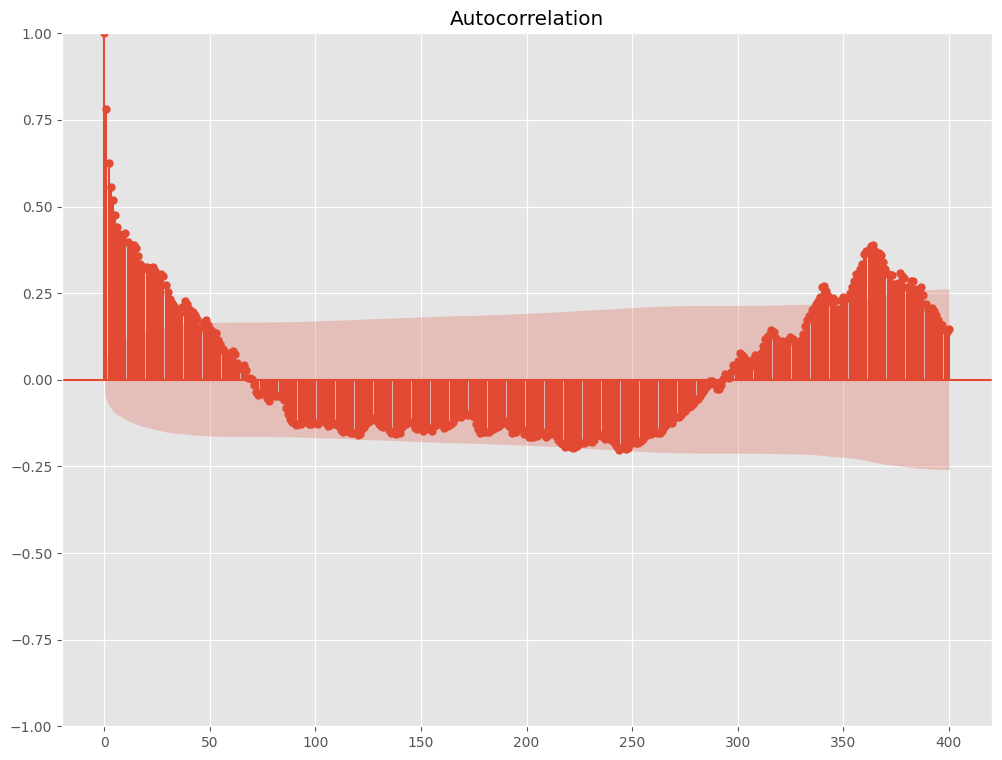

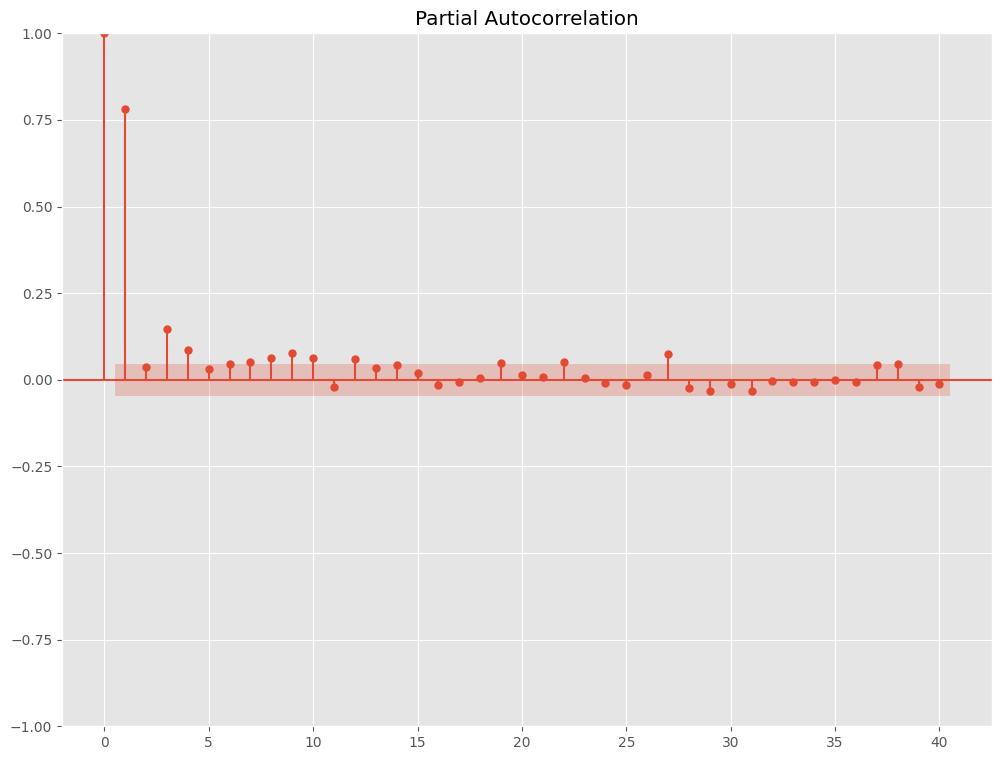

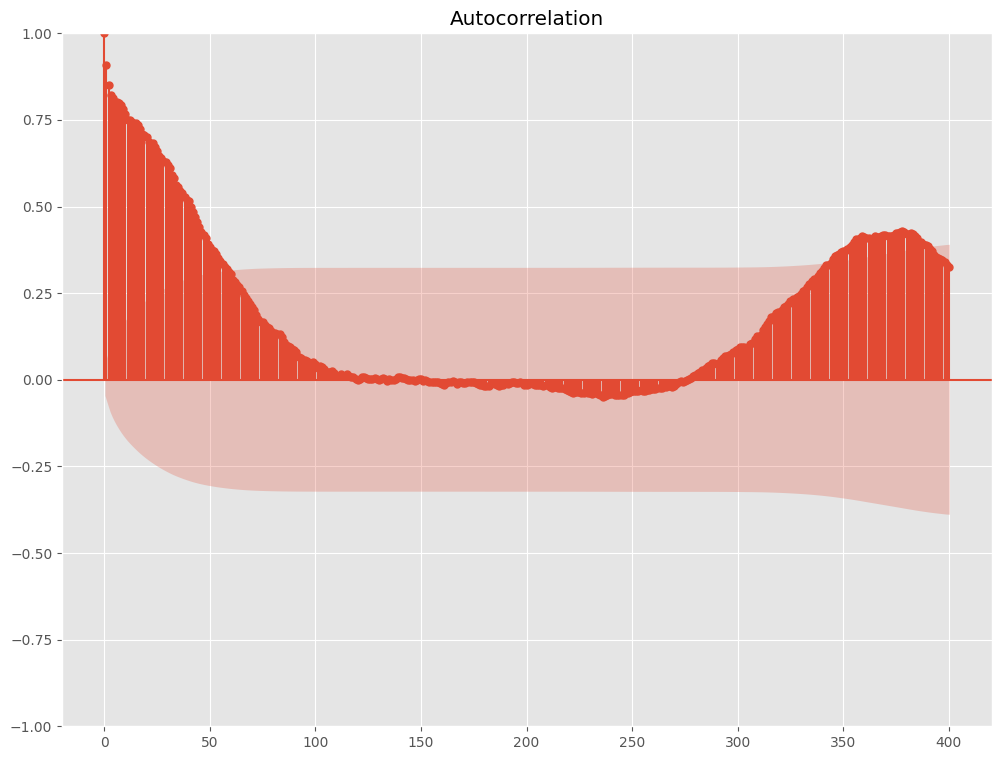

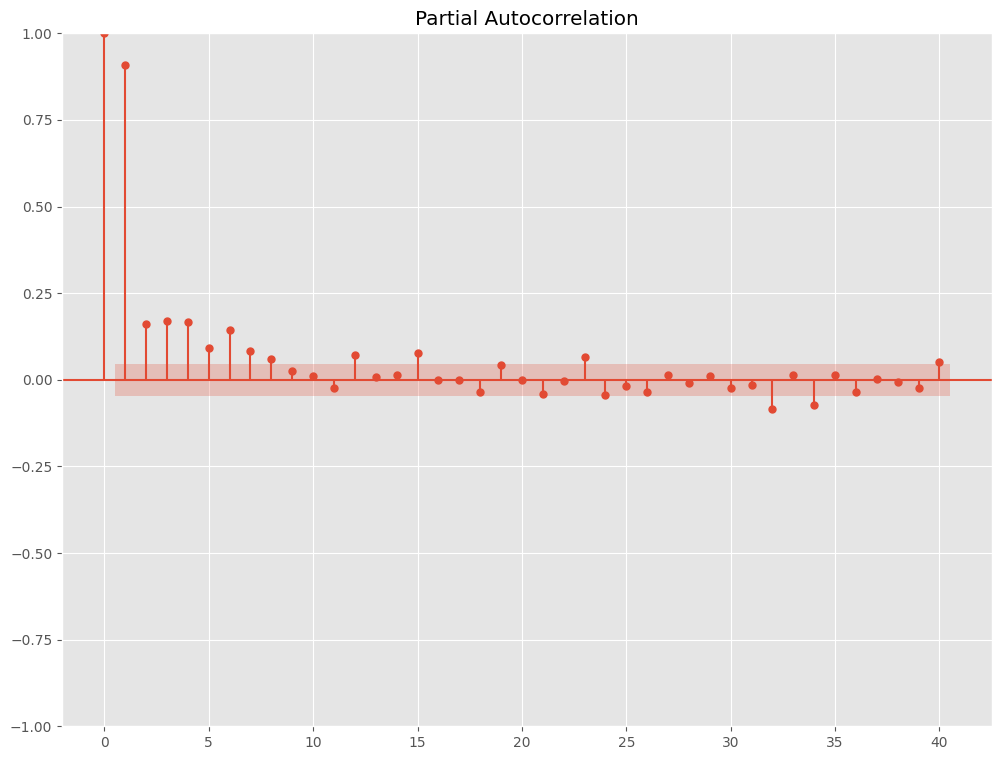

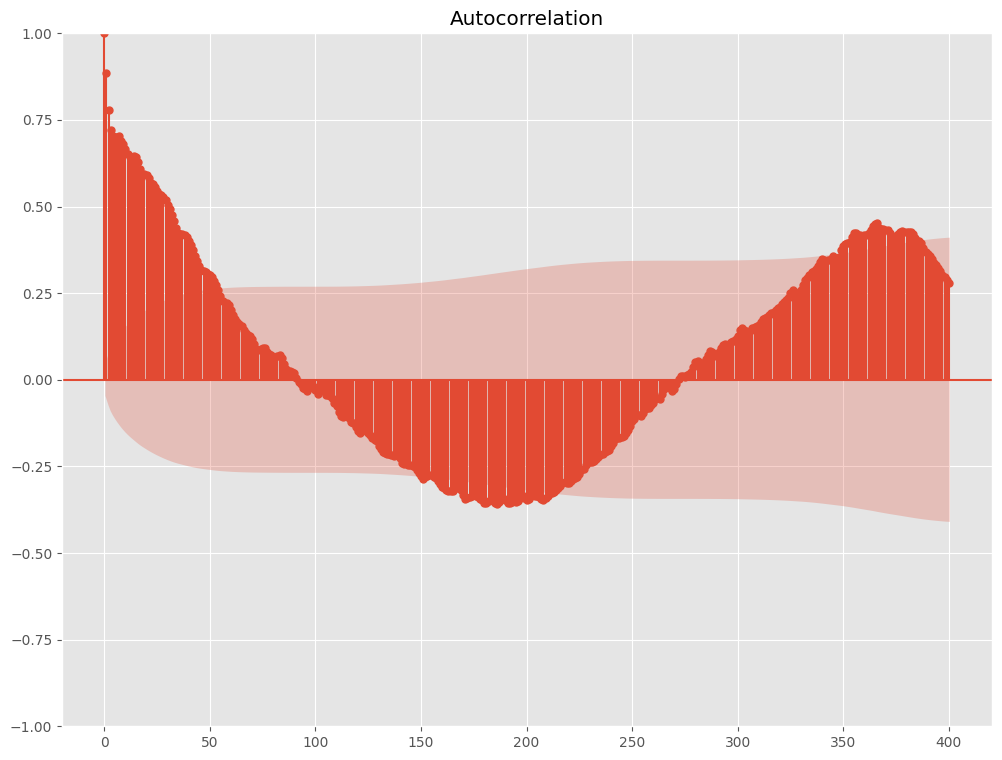

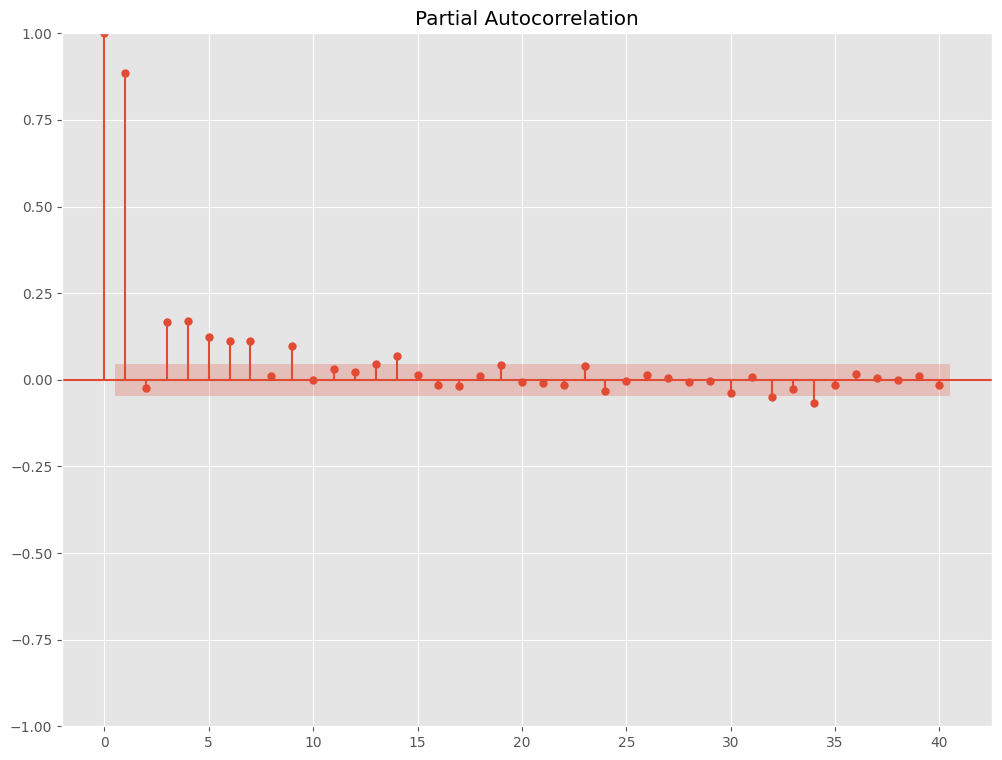

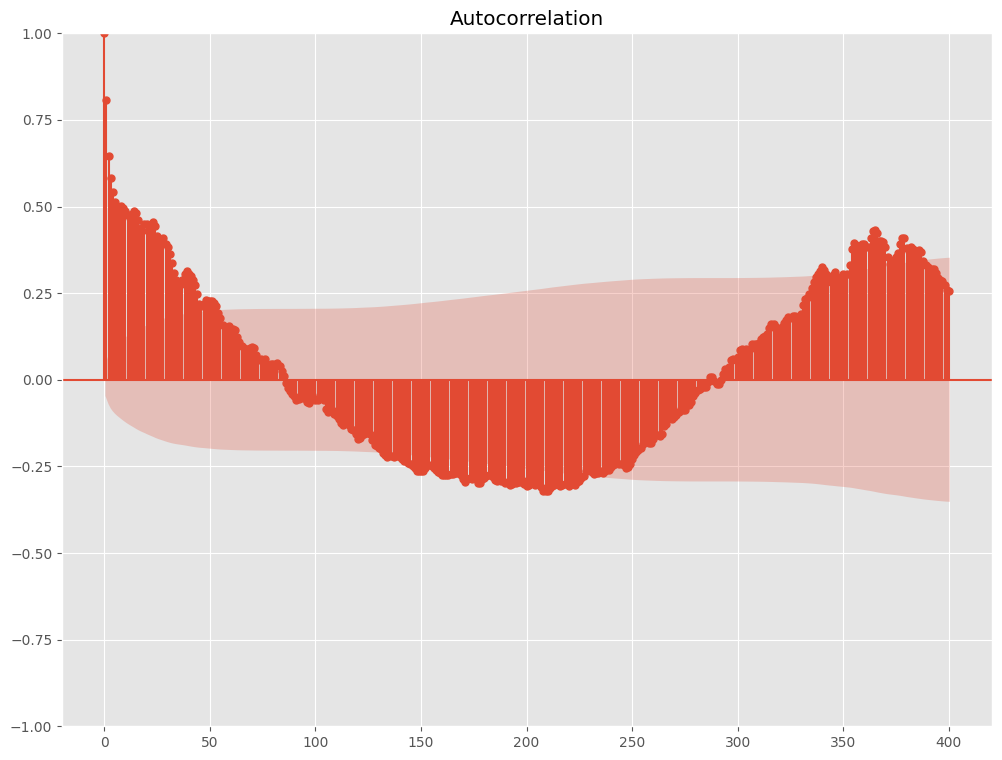

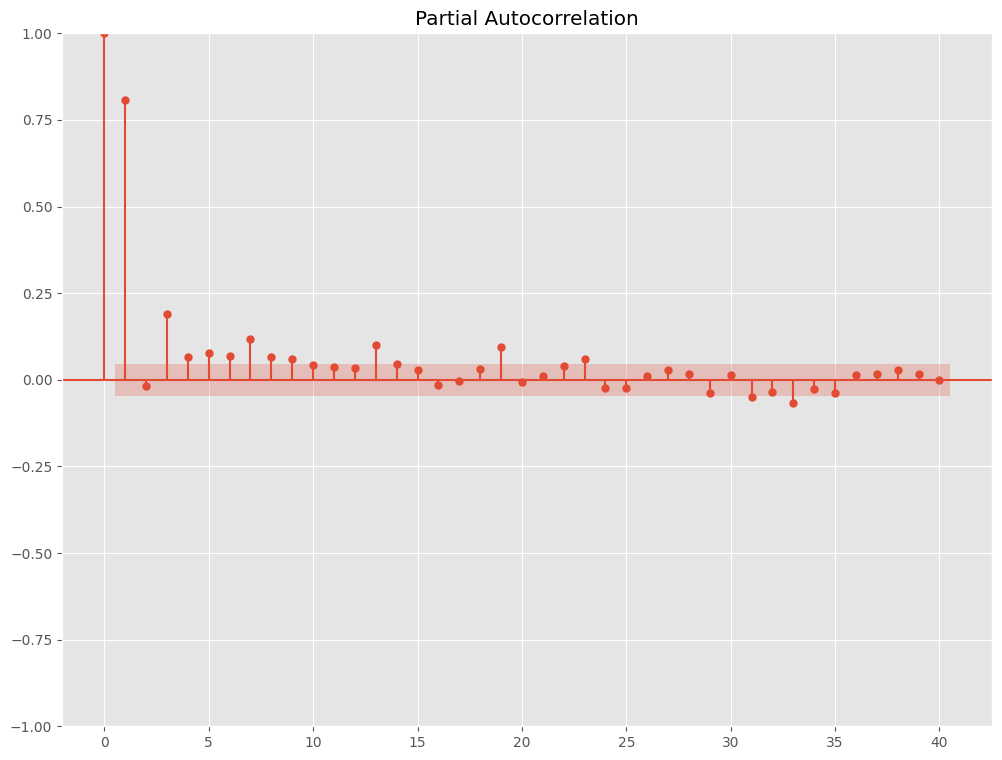

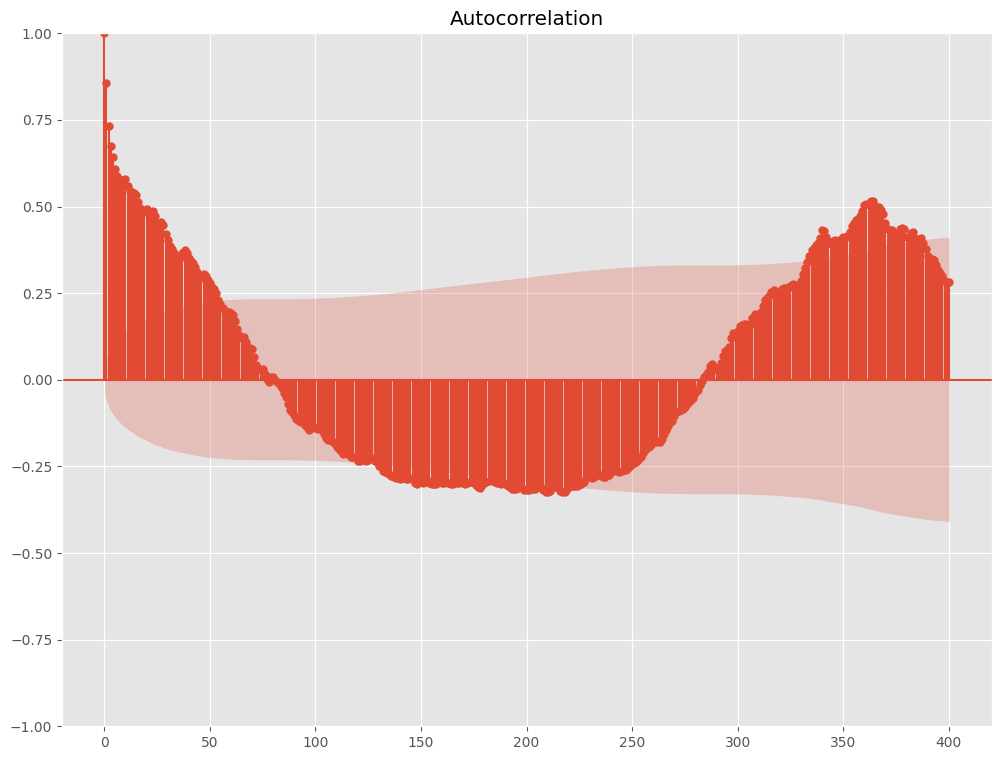

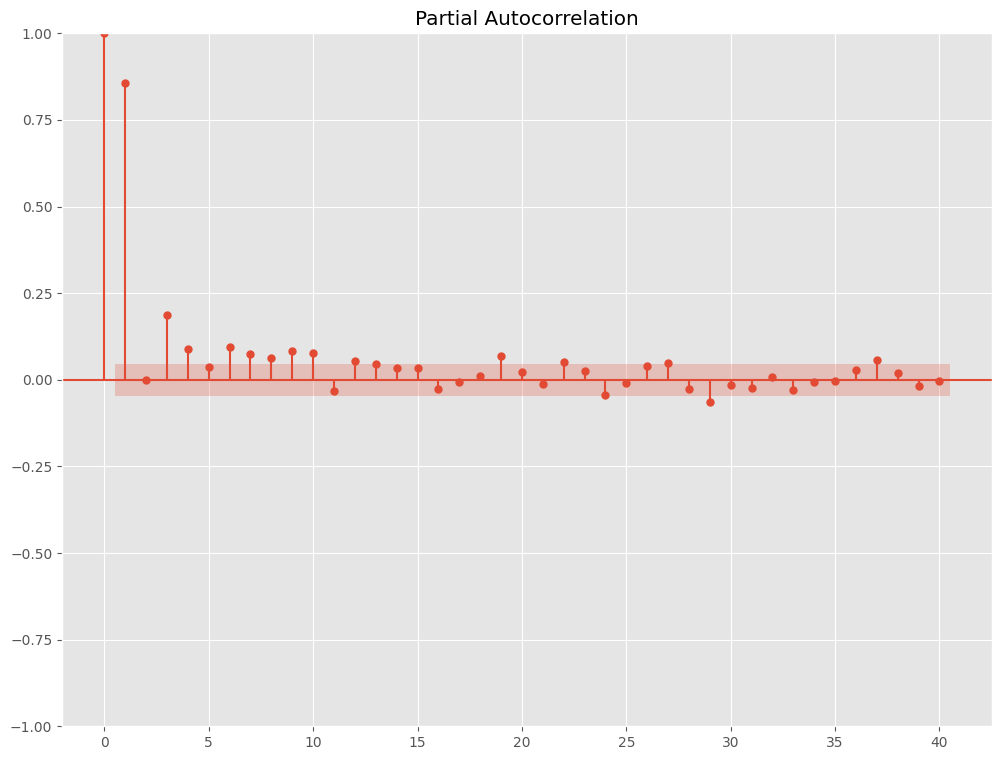

In [ ]:
#関数を動かす
create_self(Tokyo,"Tokyo")
create_self(Delhi,"Delhi")

## 相関関係

In [ ]:
#相関関係を求める関数(データフレームを作成し、グラフと共に保存する)
def create_correlation(df,city_name):
  if city_name == "Tokyo":
    df = df[["pm25","o3","pm10","so2","no2","co","AQI_total","pressure","temperature","humidity","precipitation","wind-speed"]]

  #デリーと東京で扱う説明変数の種類が違うため、条件分岐させている
  else:
    df = df[["pm25","o3","pm10","so2","no2","co","AQI_total","pressure","temperature","humidity","precipitation"]]

  df_corr = df.corr()
  sns.heatmap(df_corr)

  #グラフとデータフレームの保存
  df_corr.to_csv(f"{df_path}/{city_name}_corr_df.csv")
  plt.savefig(f'{graph_path}/{city_name}_corr.png')

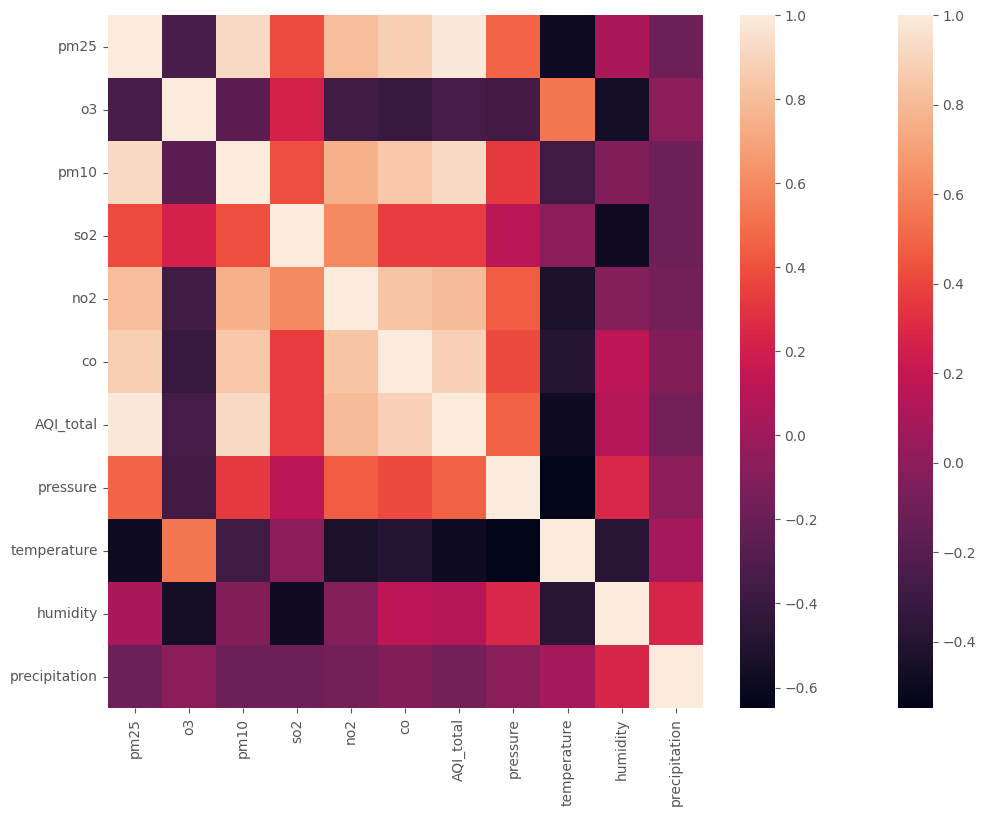

In [ ]:
#関数を動かす
create_correlation(Tokyo,"Tokyo")
create_correlation(Delhi,"Delhi")